## Define and find local maxima-clusters. Find associations (clusters, groups, NGC galaxies)

In this notebook we find local maxima in the distribution of the LSBGs (clusters) and associate these maxima with galaxy clusters, galaxy groups, and NGC galaxies.

We create a final catlog containing the information about the most prominent peaks.

In [1]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import KernelDensity
import pandas as pd
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=1.6*fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

### Part I: Kernel Density Estimation of the overdensity field

In [2]:
# Import the coordinates of the LSBGs objects
# Polygon
ra_DES, dec_DES = np.loadtxt("DES_polygon.dat", usecols=(0,1), unpack=3)

LSBG_df = pd.read_csv('LSBG_catalog.csv')


ra = LSBG_df['ra_gfm'].values
dec = LSBG_df['dec_gfm'].values

for i in range(len(ra)):
    if (ra[i] > 150.):
        ra[i] = ra[i]-360.
        
latlon = np.vstack([dec,ra]).T

In [3]:
# Import the Healpix footprint
MAP = hp.read_map('y3a2_footprint_grizY_any.fits')

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [4]:
x_min = -70.; x_max = 110.
y_min = - 70; y_max = 10.
# ============================
# Define the aspect ratio
asp_rat = (x_max-x_min)/(y_max - y_min)
base_points = 400
y_points = base_points
x_points = int(asp_rat*base_points)

In [5]:
# Create a grid of positions over which we are going to calculate the KDE
x_grid = np.linspace(x_min,x_max,x_points)
y_grid = np.linspace(y_min,y_max,y_points)

X, Y = np.meshgrid(x_grid,y_grid)
xy = np.vstack([Y.ravel(),X.ravel()]).T

Now keep only those points that are within the DES footprint.

In [6]:
# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1 

In [7]:
# Get the healpix indices xy points
HP_ind = hp.ang2pix(4096, xy[:,1], xy[:,0], lonlat=True)
xy = np.radians(xy)

In [8]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
LOCAL_mask = DES_mask[HP_ind]

ra_loc = xy[:,1]
dec_loc = xy[:,0]

# Keep those with LOCAL_mask = 1
ra_pos = ra_loc[LOCAL_mask==1]
dec_pos = dec_loc[LOCAL_mask==1]

#land_mask = np.vstack()
land_mask = xy[LOCAL_mask==1]

**Now, fit our KDE**

In [9]:
kern_size = 0.0052  # This kernel size corresponds to 0.3 deg in radians
# Fit now 
kde = KernelDensity(bandwidth=kern_size, kernel='gaussian', metric='haversine')
kde.fit(np.radians(latlon))

KernelDensity(algorithm='auto', atol=0, bandwidth=0.0052, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='haversine',
       metric_params=None, rtol=0)

In [10]:
# Evaluate on the xy map 
Z = np.exp(kde.score_samples(xy))
Z[LOCAL_mask==0] = 0
Z = Z.reshape(X.shape)

#### 5 sigma clipping

- Write my own function that performs 5-sigma clipping

In [11]:
def five_sigma_clip(X_arr, iters):
    X_old = X_arr
    for i in range(iters):
        low = np.mean(X_old) - 5.0*np.std(X_old)
        up = np.mean(X_old) + 5.0*np.std(X_old)
        X_new = X_old[(X_old>low)&(X_old<up)]
        X_old = np.copy(X_new)
        
    return X_old, low, up

In [12]:
#from astropy.stats import sigma_clip
from scipy.stats import sigmaclip as sigma_clip
Z_rav = Z.ravel()
Z_for_clip = Z_rav[Z_rav>0]
# ===================================================================
# ===================================================================
#filt_z_3sigma, low_3sigma, up_3sigma = sigma_clip(Z_for_clip, sigma=3, maxiters=12,return_bounds=True) 
#filt_z_4sigma, low_4sigma, up_4sigma = sigma_clip(Z_for_clip, sigma=4, maxiters=12,return_bounds=True) 
filt_z_5sigma, low_5sigma, up_5sigma = sigma_clip(Z_for_clip, low=5.0, high=5.0) 
print(up_5sigma)
filt_z_5sigma, low_5sigma, up_5sigma = five_sigma_clip(Z_for_clip, 15) 
print(up_5sigma)

2.484260596768504
2.484260596768504


In [13]:
from scipy.stats import gaussian_kde
#Fit kernel
kernel = gaussian_kde(Z_for_clip)
# Evaluate in a number of points ane plot to see
kde_points_eval  = np.linspace(-1.0,4.0,200)
kde_val =  kernel(kde_points_eval)

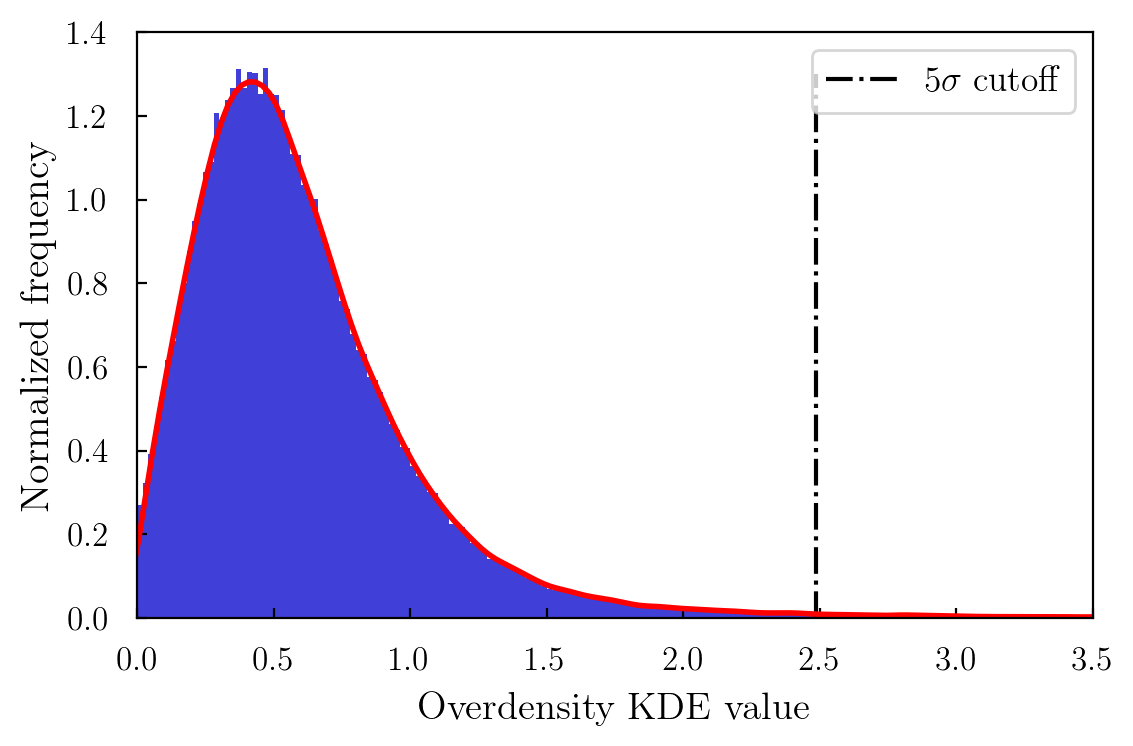

In [14]:
plt.figure(figsize = (5.91,4.0))

#plt.plot(kde_points_eval,kde_val, c='red', label='kde')
plt.hist(Z_for_clip,range=[0,4], bins=200, color='mediumblue', density=True, alpha=0.75)
plt.plot(kde_points_eval,kde_val, c='red', linewidth=2)

#plt.hist(filt_z_5sigma ,density=True)
#plt.vlines(up_3sigma,0,1.3, color='k', linestyle=':',label='3$\sigma$ cutoff')
#plt.vlines(up_4sigma,0,1.3, color='k', linestyle='--',label='4$\sigma$ cutoff')
plt.vlines(up_5sigma,0,1.3, color='k', linestyle='-.',label='5$\sigma$ cutoff')


# ===================================================================
plt.legend(loc='upper right', frameon=True, fontsize=12.8)
plt.xlim(-0.,3.5);plt.ylim(0,1.4)
plt.xlabel('Overdensity KDE value', fontsize=14);plt.ylabel('Normalized frequency', fontsize=14.5)
plt.tick_params(axis='both', labelsize=12)

plt.tight_layout()
#plt.savefig('Hist_clipping.pdf', dpi=300)
plt.show()

### Find and plot the 5 $\sigma$ maxima

In [15]:
from skimage.feature import peak_local_max
# ========================================
# ========================================
# Find the peaks that lie 5 sigma above the mean
xy_5sigma = peak_local_max(Z, min_distance=1,threshold_abs=up_5sigma)
# Print its size
print(np.shape(xy_5sigma)[0])

82


In [16]:
# Get their ra and dec
# For the 5 sigma points now
ra_s_like = xy_5sigma[:,1];dec_s_like = xy_5sigma[:,0]
ra_max_5sigma = x_grid[ra_s_like];dec_max_5sigma = y_grid[dec_s_like]
ra_5s = ra_max_5sigma;dec_5s = dec_max_5sigma 
np.savetxt('Peaks_coords.dat', np.c_[ra_5s, dec_5s], fmt='%.6f %.6f ')

In [17]:
import skymap as smap
from skymap import DESSkymap

//anaconda/envs/python2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:4759: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if fix_wrap_around and itemindex:


may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/contour.py:1006: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)
//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2484: UserWarning: Saw kwargs [u'lw', u'linewidth'] which are all aliases for u'linewidth'.  Kept value from u'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


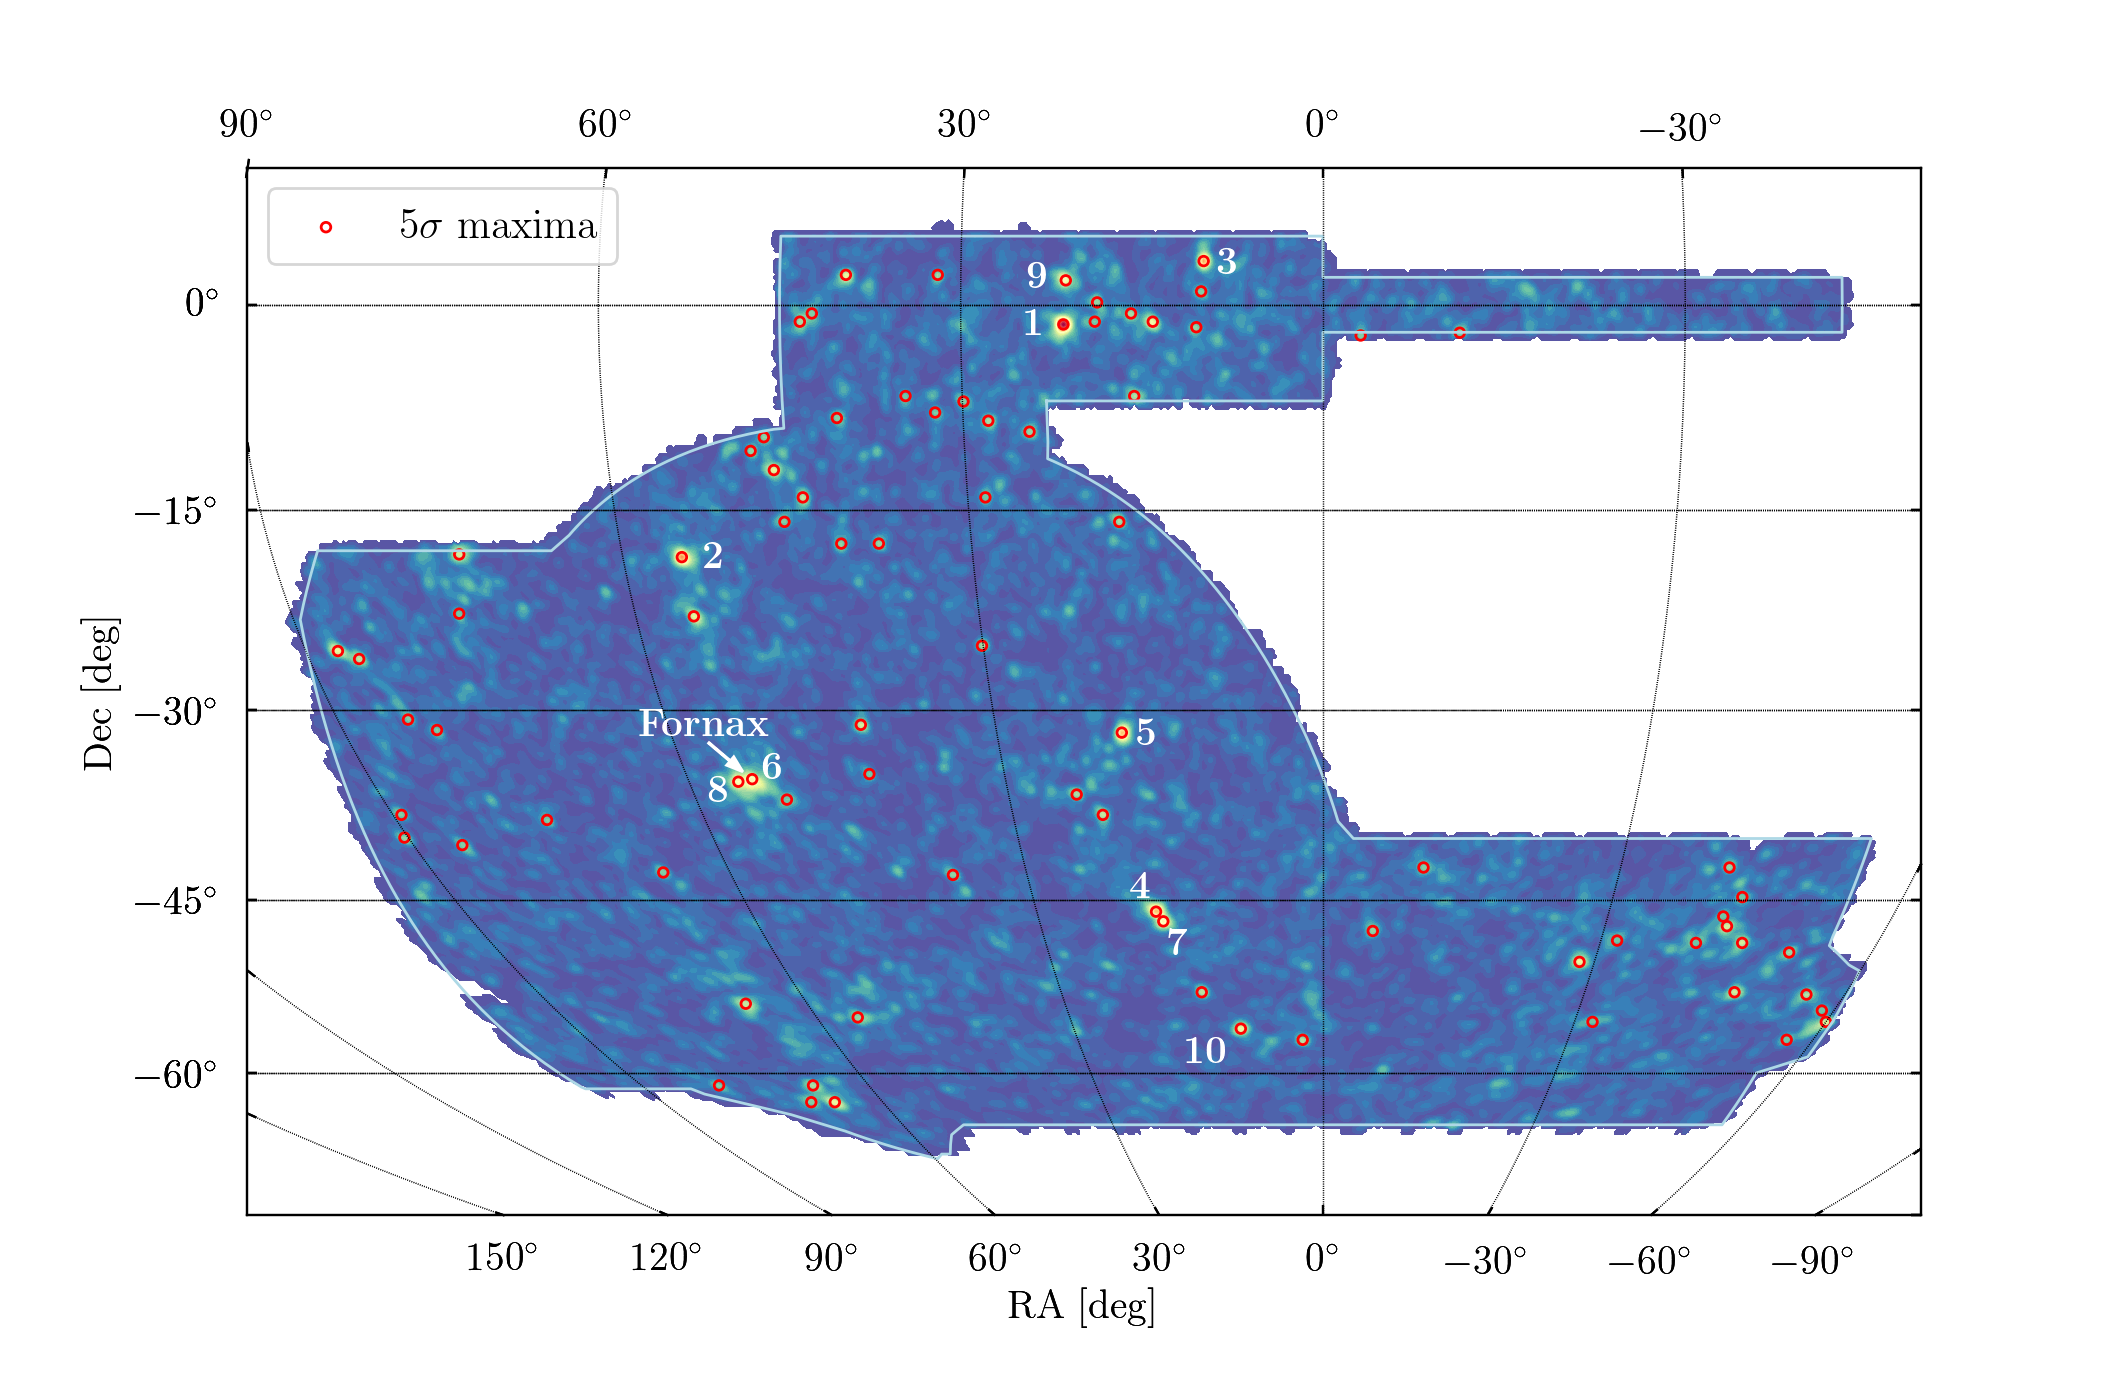

In [18]:
levels = np.linspace(1e-6, Z.max(),40)

plt.figure(figsize = (0.9*12.0,0.9*8.0))

smap = DESSkymap()

# ================================================================
# Put names 
plt.text(2.540938504519237, 1.2865569654111808,r'\textbf{1}',color='w', fontsize=14)
plt.text(2.1062015247704826, 0.970531782210,r'\textbf{2}',color='w', fontsize=14)
plt.text(2.6931219940795184, 0.73035200028980,r'\textbf{5}',color='w', fontsize=14)
plt.text(2.8009674499011963, 1.3684745078799,r'\textbf{3}',color='w', fontsize=14)
plt.text(2.6830332887819712, 0.522280908573,r'\textbf{4}',color='w', fontsize=14)
plt.text(2.1843926268543234, 0.6850023706,r'\textbf{6}',color='w', fontsize=14)
plt.text(2.5441016103554097, 1.3498585836,r'\textbf{9}',color='w', fontsize=14)
plt.text(2.1112511833316, 0.653899412,r'\textbf{8}',color='w', fontsize=14)
plt.text(2.734666087694691, 0.445851757509,r'\textbf{7}',color='w', fontsize=14)
plt.text(2.76, 0.30,r'\textbf{10}',color='w', fontsize=14)

#smap.text(24.7,-2.1,r'\textbf{1}',color='w', fontsize=14)

smap.contourf(X,Y,Z, levels=levels,rasterized=True, cmap='Spectral_r',latlon=True)
#smap.scatter(ra,dec,color='blue',s=0.01,latlon=True)
smap.draw_des(color='lightblue',linewidth=1.0)
smap.scatter(ra_5s, dec_5s, s=12,facecolors='none', edgecolors='r',label='$5\sigma$ maxima',latlon=True)
plt.text(2.018806490724194, 0.7408844464875,r'\textbf{Fornax}',color='w', fontsize=14)
plt.arrow(2.11292837490, 0.732105712,0.0289050795206,-0.0244889086,color='w',head_width=0.015)
plt.xlabel("RA [deg]", fontsize=20)
plt.ylabel("Dec [deg]", fontsize=20)

plt.legend(frameon=True, loc='upper left', fontsize=15)
plt.tight_layout()
plt.savefig('KDE_peaks.pdf', dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()

### Create a catalog of peaks and associations

Create now a catalog-csv file that contains the 82 peaks and their associations.

In [19]:
# Find the most prominent peaks
peaks = np.zeros([82,2])
peaks[:,0] = dec_5s;peaks[:,1] = ra_5s
Z_peaks = np.exp(kde.score_samples(np.radians(peaks)))

In [20]:
sort_indx = np.argsort(Z_peaks)
sort_indx = sort_indx[::-1]
print(sort_indx)

[70 49 81 24 40 38 22 37 78  6 71 45 15  0 80 57 47  7 21 50 17 42 13 11
 33 56 44 14  5 12 65  2 36 74 61 73 53 46 79 16 28 76 58 60 51 68 26 20
 69  9 31 59 52 27 62 67  1 54 75 64 77 30 29 32  3 43 34 63 39 72 35 41
  4 55 48 10 18 66 25 23 19  8]


In [21]:
ra_sort = ra_5s[sort_indx];dec_sort=dec_5s[sort_indx]
for i in range(82):
    print(i+1,ra_sort[i],dec_sort[i])

(1, 21.50166852057842, -1.4285714285714306)
(2, 54.938820912124584, -18.471177944862156)
(3, 9.888765294771972, 3.1829573934837043)
(4, 17.49721913236931, -45.93984962406015)
(5, 18.49833147942158, -31.704260651629077)
(6, 53.93770856507231, -35.31328320802005)
(7, 16.896551724137936, -46.74185463659148)
(8, 55.339265850945495, -35.51378446115288)
(9, 21.30144605116797, 1.7794486215538825)
(10, 9.888765294771972, -55.96491228070175)
(11, 14.093437152391544, -1.228070175438603)
(12, 87.17463848720803, -25.48872180451128)
(13, -28.35372636262514, -50.150375939849624)
(14, 66.55172413793105, -62.78195488721805)
(15, 39.52169076751947, 2.1804511278195378)
(16, 46.12903225806453, -12.05513784461153)
(17, 54.938820912124584, -22.882205513784463)
(18, -59.988876529477196, -55.363408521303256)
(19, -42.96996662958843, -47.142857142857146)
(20, 73.95995550611792, -18.270676691729328)
(21, -45.37263626251391, -48.54636591478697)
(22, 42.32480533926585, -31.10275689223058)
(23, -47.17463848720801

## Import external catalogs

### Abell Catalog

In [22]:
# Open and read the Abell catalog
Abell_cat = fits.open('Abell.fits')
# ================================================
name_Abell = Abell_cat[1].data['NAME']
ra_Abell = Abell_cat[1].data['RA']
dec_Abell = Abell_cat[1].data['DEC']
z_Abell = Abell_cat[1].data['REDSHIFT']
rich_Abell = Abell_cat[1].data['RICH']
dist_Abell = Abell_cat[1].data['DIST']
# Transform RA and DEC
# ================================================
# ================================================
for i in range(len(ra_Abell)):
    if (ra_Abell[i] > 180.):
        ra_Abell[i] = ra_Abell[i]-360.
# ====================================
# ====================================
#print Abell_cat[1].header.keys
print(len(ra_Abell))

5250


### Reflex catalog

In [23]:
# Open and read the Reflex catalog
Reflex_cat = fits.open('Reflex.fits')

name_Reflex = Reflex_cat[1].data['name']
ra_Reflex = Reflex_cat[1].data['ra']
dec_Reflex = Reflex_cat[1].data['dec']
z_Reflex = Reflex_cat[1].data['redshift']

for i in range(len(ra_Reflex)):
    if (ra_Reflex[i] > 180.):
        ra_Reflex[i] = ra_Reflex[i]-360.

print(len(name_Reflex))
#print Reflex_cat[1].header.keys

447


### NGC catalog (keep only the galaxies)

In [24]:
# Open and read the NGC catalog
NGC_cat = fits.open('NGC_2.fit')

# ================================================
ra_NGC = NGC_cat[1].data['_RAJ2000']
dec_NGC = NGC_cat[1].data['_DEJ2000']
type_NGC = NGC_cat[1].data['Type']
name_NGC = NGC_cat[1].data['NGC']
ra_NGC = ra_NGC[type_NGC==5]
dec_NGC = dec_NGC[type_NGC==5]
name_NGC = name_NGC[type_NGC==5]
type_NGC = type_NGC[type_NGC==5]

        
for i in range(len(ra_NGC)):
    if (ra_NGC[i] > 180.):
        ra_NGC[i] = ra_NGC[i]-360.

print(len(ra_NGC))
#print NGC_cat[1].header.keys

6260


### 2Mass group catalog 

From arXiv: 1503.03134: 

Galaxy Groups: A 2MASS Catalog

In [25]:
# =============================================
# Open and read the 2Mass catalog
twomass_cat = fits.open('2Mass.fit')


ra_2Mass = twomass_cat[1].data['_RA_ICRS']
dec_2Mass = twomass_cat[1].data['_DE_ICRS']
Nmb_2Mass = twomass_cat[1].data['Nmb']
name_2Mass = twomass_cat[1].data['Nest']
DM_2Mass = twomass_cat[1].data['DM']

# Keep only those with >=5 members
ra_2Mass = ra_2Mass[Nmb_2Mass>=5]
dec_2Mass = dec_2Mass[Nmb_2Mass>=5]
name_2Mass = name_2Mass[Nmb_2Mass>=5]
DM_2Mass = DM_2Mass[Nmb_2Mass>=5]
Nmb_2Mass = Nmb_2Mass[Nmb_2Mass>=5]


for i in range(len(ra_2Mass)):
    if (ra_2Mass[i] > 180.):
        ra_2Mass[i] = ra_2Mass[i]-360.

print(len(ra_2Mass))
#print twomass_cat[1].header.keys

1120


### Inspection

So, we have four external catalogs. Let's inspect within $0.5$ of a degree around each of the peaks.

In [26]:
num = 37
angle = 0.5
# =====================================
# =====================================
ra_c = ra_sort[num]
dec_c = dec_sort[num]

ra_min = ra_c - angle
ra_max = ra_c + angle

dec_min = dec_c - angle
dec_max = dec_c + angle
# =====================================
# =====================================

# Box for Abell
box_Abell = (ra_Abell>ra_min)&(ra_Abell<ra_max)&(dec_Abell>dec_min)&(dec_Abell<dec_max)
# Box for Reflex 
box_Reflex = (ra_Reflex>ra_min)&(ra_Reflex<ra_max)&(dec_Reflex>dec_min)&(dec_Reflex<dec_max)
# Box NGC 
box_NGC = (ra_NGC>ra_min)&(ra_NGC<ra_max)&(dec_NGC>dec_min)&(dec_NGC<dec_max)
# Box 2Mass
box_2Mass = (ra_2Mass>ra_min)&(ra_2Mass<ra_max)&(dec_2Mass>dec_min)&(dec_2Mass<dec_max)
# Box LSBGs
box_LSBGs = (ra>ra_min)&(ra<ra_max)&(dec>dec_min)&(dec<dec_max)

Keep only the objects within the specified limits from each one of the catalogs

In [27]:
# Abell
ra_Abell_box = ra_Abell[box_Abell];dec_Abell_box=dec_Abell[box_Abell]
name_Abell_box = name_Abell[box_Abell]
z_Abell_box = z_Abell[box_Abell];rich_Abell_box = rich_Abell[box_Abell];dist_Abell_box = dist_Abell[box_Abell]
# Reflex
ra_Reflex_box = ra_Reflex[box_Reflex];dec_Reflex_box=dec_Reflex[box_Reflex]
name_Reflex_box = name_Reflex[box_Reflex];z_Reflex_box = z_Reflex[box_Reflex]
# NGC 
ra_NGC_box = ra_NGC[box_NGC];dec_NGC_box=dec_NGC[box_NGC]
name_NGC_box = name_NGC[box_NGC]
# 2Mass 
ra_2Mass_box = ra_2Mass[box_2Mass];dec_2Mass_box=dec_2Mass[box_2Mass]
name_2Mass_box = name_2Mass[box_2Mass];Nmb_2Mass_box = Nmb_2Mass[box_2Mass]
# LSBGs
ra_LSBG = ra[box_LSBGs];dec_LSBG = dec[box_LSBGs]

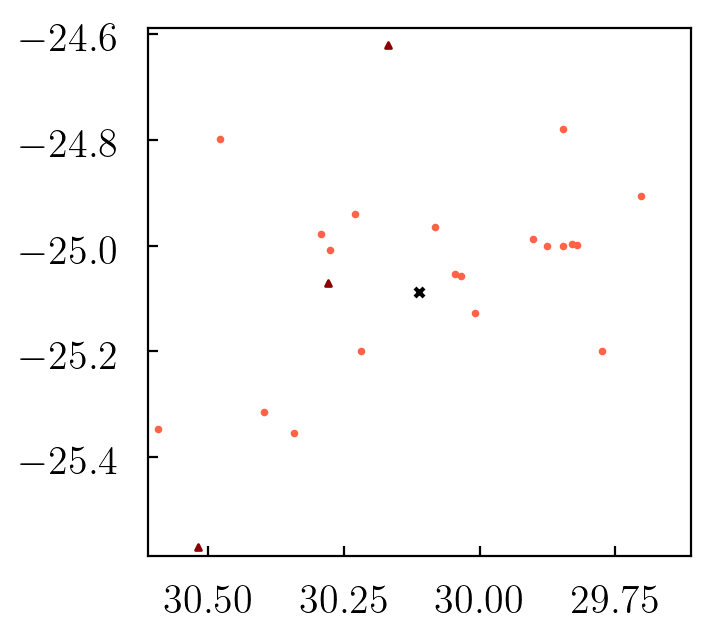

In [28]:
plt.figure(figsize = (3.5,3.5))


plt.scatter(ra_c, dec_c, c='k', s=10.5, marker='x', label='$5\sigma$ maximum')
plt.scatter(ra_Abell_box, dec_Abell_box, c='darkred', marker='^', s=4.5, label='Abell')
plt.scatter(ra_Reflex_box, dec_Reflex_box, c='g', s=2.5, label='Reflex')
plt.scatter(ra_NGC_box, dec_NGC_box, c='mediumblue', s=5.5, label='NGC')
plt.scatter(ra_2Mass_box, dec_2Mass_box, c='orange', s=2.5, label='2mass ')
plt.scatter(ra_LSBG, dec_LSBG, c='tomato', s=3)
#plt.legend(loc='upper right', frameon=True, fontsize=8)
plt.xlim(ra_max,ra_min);plt.ylim(dec_min,dec_max)
plt.show()

In [29]:
print(ra_c,dec_c)
print(name_Abell_box)
print(name_Reflex_box)
print(name_NGC_box)
print(name_2Mass_box)
print(ra_2Mass_box)
print(dec_2Mass_box)

(30.111234705228043, -25.087719298245617)
['ABELL297' 'ABELL2964' 'ABELL289']
[]
[]
[]
[]
[]


### Create the csv file of peaks.

In [30]:
peaks = pd.read_csv("peaks_associations.csv")
# =============================================
# =============================================
ra_assoc_old = peaks['ra_assoc'].values
best_assoc_old = peaks['best_assoc'].values
z_assoc_old = peaks['z_assoc'].values
dist_assoc_old = peaks['dist_assoc'].values
err_dist_old = peaks['err_dist'].values
qual_old = peaks['quality'].values

In [31]:
i = 79-1
print(ra_assoc_old[i])
print(z_assoc_old[i])
print(best_assoc_old[i])
print(dist_assoc_old[i])
#print(err_dist_old[i])
print(qual_old[i])

-43.292291
0.028999999999999998
Abell S921
125.41
I


In [78]:
ra_assoc = [21.42,55.0475,9.888208,17.501667,18.475833,54.61625,16.929944,
           54.61625,21.374583,10.0270,14.07625,87.165,-28.895764,-1,39.6552,45.977,54.841042,
           -1,-43.026855,73.709583,-45.456833,42.403750,-47.180386,67.2825,21.519167,-1,
           85.538750,14.2444,2.548852,-55.31,15.4844,67.850417,23.573,16.2053,27.862913,
           43.216296,17.23,30.275154,67.850417,-1,-40.7727,18.80,47.746,24.314167,37.86128,
           -11.2336,37.4553,-1,10.653458,55.186208,90.440417,46.549625,41.343458,66.8742,
           40.749254,-3.1544119,-1,-1,-1,-1,9.895083,85.026250,-10.225,75.193750,80.089400,
           83.600588,-1,32.176575,-1,18.661021,50.673825,81.386667,-56.872917,28.252077,
           75.378314,-58.588333,-40.248736,34.771583,-43.292291,-1,-31.823217,-32.155417]

In [79]:
dec_assoc = [-1.407222,-18.5875,3.138528,-45.922778,-31.751944,-35.448333,-46.916526,
            -35.448333,1.762778,-56.11666,-1.216667,-25.4584,-50.073809,-1,1.9749,
            -11.991806,-22.724694,-1,-47.181170,-18.109167,-48.630306,-31.188611,
            -52.695408,-53.8475,-37.976667,-1,-26.123611,-52.9735,-56.988390,-52.706111,
            -6.2993,-61.443889,-36.5483,-0.8359,-8.505370,-1.274695,-15.628889,-25.075489,
            -61.443889,-1,-42.2345,0.33,-10.7192,-9.202778,-17.645962,
            -2.0919,-42.9687,-1,-1.528778,-55.207035,-39.992778,-9.541417,
            -17.533167,-42.5733,-8.289498,-2.325994,-1,-1,-1,-1,0.859889,-40.842222,-42.113889,
            -38.678056,-61.285036,-30.801117,-1,-7.790539,-1,-1.020647,-37.208227,
            -31.595556,-56.831944,-13.738653,-22.611789,-54.375611,-48.562160,
            -6.790917,-44.832033,-1,-48.397871,-55.353333]

In [80]:
z_assoc = [0.018,0.0057,0.01535,0.0247,0.02,0.0046,0.0237,0.0046,0.01739,0.0277,0.0442,
          0.03947,0.03630,-1,-1,0.0135,0.00499,-1,0.01620,0.03346,0.01748,0.02230,
          0.0462,0.0394,0.08080,-1,0.04290,-1,0.03120,0.05040,-1,0.05890,-1,-0.8359,
          0.01827,0.02313,0.09810,0.01440,0.05890,-1,-1,0.0450,-1,0.03920,0.03188,-1,-1,-1,
          0.01767,0.04250,0.0456,0.01454,0.02942,-1,0.03182,0.02180,-1,-1,-1,-1,
          0.01473,0.0358,0.04500,0.05360,-1,0.03586,-1,0.01353,-1,0.01864,0.00587,
          0.03790,0.0556,0.00582,0.04670,0.01907,0.00762,0.01816,0.02900,-1,0.00644,
          0.0385]

In [81]:
best_assoc = ['Abell 194','RXC J0340.1-1835','NGC 199','Abell 2877','Abell S141','Abell S373',
             'Abell 2870','Abell S373','RXC J0125.5+0145','Abell 2806','Abell 119','RXC J0548.6-2527',
             'Abell S989','None','2MASS 200052','NGC 1200','NGC 1401','None','Abell S924',
             'RXC J0454.8-1806','NGC 6987','Abell S301','Abell 3716','Abell S463',
             'Abell 2911','None','RXC J0542.1-2607','2MASS 200104','Abell 2731','Abell S861',
             '2MASS 200153','Abell 3266','2MASS 200185','2MASS 200530','NGC 707','RXC J0252.8-0116',
             'RXC J0108.9-1537','Abell 2964','Abell 3266','None','2MASS 200476','Abell 168',
             '2MASS 200462','RXC J0137.2-0912','Abell S273','2MASS 200078','2MASS 200194',
             'None','NGC 227','Abell S377','Abell 3376','NGC 1208','NGC 1091','2MASS 200531',
             'NGC 1069','RXC J2347.4-0218','None','None','None','None', 'NGC 201',
             'Abell S540','Abell S1111','Abell 3301','Abell S524','Abell S536','None',
             'NGC 829','None','NGC 442','NGC 1316','Abell 3341','Abell 3667','RXC J0152.9-1345',
             'Abell 533','NGC 6854','NGC 7049','NGC 883','Abell S921','None','Abell 3820',
              'RXC J2151.3-5521']

In [82]:
dist_assoc = [75.07,23.41,62.81,106.41,84.80,18.97,102.03,18.97,72.32,120.23,190.58,175.61,157.68,
             -1,-1,57.03,20.34,-1,68.93,147.75,74.77,96.24,202.12,174.16,354.11,-1,190.62,-1,
             135.65,220.99,-1,260.57,-1,-1,76.75,99.20,429.38,60.31,260.57,-1,-1,194.31,-1,
             169.12,137.85,-1,-1,-1,73.13,187.27,202.95,61.56,127.18,-1,137.54,91.06,-1,-1,
             -1,-1,60.07,159.23,195.40,237.21,-1,159.35,-1,56.05,-1,77.76,24.38,168.20,
             244.3,21.87,206.52,82.70,31.03,76.66,125.41,-1,25.59,167.88]

In [83]:
err_dist = [5.26,1.64,4.41,7.45,5.94,1.33,7.14,1.33,5.10,8.42,13.34,12.29,11.04,-1,-1,4.01,
           1.47,-1,4.83,10.36,5.25,6.74,14.15,12.19,24.79,-1,13.35,-1,9.50,15.47,-1,18.24,
           -1,-1,5.38,6.95,30.06,4.23,18.24,-1,-1,13.61,-1,11.84,9.65,-1,-1,-1,5.15,13.11,
           14.21,4.32,4.32,-1,9.63,6.38,-1,-1,-1,-1,4.23,11.15,19.06,16.60,-1,11.15,-1,3.93,
           -1,5.46,1.72,11.77,17.10,1.56,14.46,5.80,2.18,5.38,8.78,-1,-1,11.75]

In [84]:
quality = ['I','I','II','I','I','I','I','I','I','II','I','I','III','III','II','II','II','I',
          'I','II','I','I','I','I','II','III','I','III','I','II','II','II','II','III','I','I',
          'II','II','II','I','II','I','II','I','II','II','II','III','III','II','I','II','II',
          'II','II','I','I','III','III','I','II','III','II','I','II','I','I','II','I','III',
          'II','I','II','II','I','III','II','II','I','III','II','I']

In [85]:
j=78
print(best_assoc[j])
print(ra_assoc[j])
print(dec_assoc[j])

Abell S921
-43.292291
-44.832033


In [86]:
print(len(ra_assoc))
print(len(dec_assoc))

82
82


### Number of LSBGs withing 0.5 deg from each one of the maxima

Now I want to find the number of LSBGs that lie withing 0.5 degrees (as calculated using the astropy distance) from each one of the 5sigma maxima.

In [516]:
from astropy import units as u
from astropy.coordinates import SkyCoord
# Create a catalog for the LSBG galaxies
C_LSBGs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
n_maxima = 82 #Number of maxima
num_LSBGs = np.zeros(n_maxima, dtype=int)#Empty array 

max_sep = 0.5 #Separation to keep, in degrees

for i in range(n_maxima):
    # The coordinates of the i-th peak
    ra_loc = ra_5s[i]
    dec_loc = dec_5s[i]
    # Define an object for the position of the i-th maximum 
    C_loc = SkyCoord(ra=ra_loc*u.degree, dec=dec_loc*u.degree, frame='icrs')
    # ======================================================================
    # ======================================================================
    # Get the separation between this maximum and the objects in the LSBGs catalog
    sep_LSBGs = C_LSBGs.separation(C_loc).deg
    
    # Now keep objects that are within the separation limit
    ra_loc = ra[sep_LSBGs<max_sep]
    
    num_LSBGs[i] = len(ra_loc)
    
    
# ==============================================================================
# ==============================================================================

In [517]:
num_LSBGs_sort = num_LSBGs[sort_indx]
print(num_LSBGs_sort)
peak_number = np.arange(1,83)

[68 48 46 41 42 32 36 28 28 32 32 29 28 27 27 30 28 26 23 25 23 22 27 24
 19 20 22 22 19 18 20 22 21 18 22 20 19 19 16 18 15 17 17 19 19 20 18 18
 18 20 18 17 18 18 16 14 17 14 18 16 18 15 15 16 14 15 18 15 13 17 18 13
 15 13 16 14 13 14 13 14 13 15]


In [518]:
import pandas as pd
from collections import OrderedDict

In [519]:
peak_df = pd.DataFrame( OrderedDict(( 
    ('peak_number', pd.Series(peak_number)),
    ('ra_peak', pd.Series(ra_sort)),
    ('dec_peak', pd.Series(dec_sort)),
    ('best_assoc',pd.Series(best_assoc)), 
    ('ra_assoc', pd.Series(ra_assoc)),
    ('dec_assoc', pd.Series(dec_assoc)),
    ('z_assoc', pd.Series(z_assoc)),
    ('dist_assoc', pd.Series(dist_assoc)),
    ('err_dist', pd.Series(err_dist)),
    ('n_05', pd.Series(num_LSBGs_sort)),
    ('quality', pd.Series(quality))
)))

In [520]:
peak_df.head(11)

,peak_number,ra_peak,dec_peak,best_assoc,ra_assoc,dec_assoc,z_assoc,dist_assoc,err_dist,n_05,quality
0,1,21.501669,-1.428571,Abell 194,21.420000,-1.407222,0.01800,75.07,5.26,68,I
1,2,54.938821,-18.471178,RXC J0340.1-1835,55.047500,-18.587500,0.00570,23.41,1.64,48,I
2,3,9.888765,3.182957,NGC 199,9.888208,3.138528,0.01535,62.81,4.41,46,II
3,4,17.497219,-45.939850,Abell 2877,17.501667,-45.922778,0.02470,106.41,7.45,41,I
4,5,18.498331,-31.704261,Abell S141,18.475833,-31.751944,0.02000,84.80,5.94,42,I
5,6,53.937709,-35.313283,Abell S373,54.616250,-35.448333,0.00460,18.97,1.33,32,I
6,7,16.896552,-46.741855,Abell 2870,16.929944,-46.916526,0.02370,102.03,7.14,36,I
7,8,55.339266,-35.513784,Abell S373,54.616250,-35.448333,0.00460,18.97,1.33,28,I
8,9,21.301446,1.779449,RXC J0125.5+0145,21.374583,1.762778,0.01739,72.32,5.10,28,I
9,10,9.888765,-55.964912,Abell 2806,10.027000,-56.116660,0.02770,120.23,8.42,32,II


In [521]:
peak_df.to_csv('peaks_associations.csv')

In [522]:
import numpy as np
BA = np.asarray(best_assoc)
Q = np.asarray(quality)

ind = [i for i,x in enumerate(best_assoc) if x=='None'] # => [1, 3]
print(Q[ind])

['III' 'I' 'III' 'I' 'III' 'I' 'III' 'III' 'I' 'I' 'I' 'III']


## Relationship between cluster Mass and Number of LSBGs

In [523]:
# Create an array with the X-ray luminosities
Lum = [0.074,0.002,0.195,0.036,0.077,1.568,0.597,0.156,0.089,0.164,0.268,0.754,4.416,0.091,0.889,
      0.503,0.316,1.079,0.033,0.481,0.527,0.403,5.405,0.001,0.113]

In [541]:
# Indices corresponding to clusters with 
indices = [0,1,3,8,9,10,11,19,21,23,26,29,31,35,36,41,
          43,50,55,61,63,71,72,73,81]

# Get the names of the associations with X-ray luminosities
names = np.asarray([best_assoc[i] for i in indices])

# Get the redshifts of the associations with X-ray luminosities
z_xray = np.asarray([z_assoc[i] for i in indices])

# Get the distances to these clusters - in Mpc
dist_xray = np.asarray([dist_assoc[i] for i in indices])

Lum = np.asarray(Lum)
# ==========================================================
# Get coordinates of the associations with X-ray luminosities
ra_xray = np.asarray([ra_assoc[i] for i in indices])
dec_xray = np.asarray([dec_assoc[i] for i in indices])

# Number of lSBGs within 0.5 deg
n_xray = np.asarray([num_LSBGs[i] for i in indices])

print(len(dist_xray[dist_xray<123]))

9


### Mass calculation

In [548]:
# Parameters 
Om_m = 0.3
Om_Lambda = 0.7
a_sl = 1.57
h_par = 0.7
# ================================================
# ================================================
# Calculate H(z)/H_0
E_z = np.sqrt(Om_m*((1.0+z_xray)**3.0)+Om_Lambda)

# Convert Luminosity to the correct units
Lum_corr = Lum*(h_par**2.0)

# Calculate mass
Mass_clust = np.asarray((h_par**2.0/E_z)*((Lum_corr/0.1175)**(1.0/a_sl)))

print(n_xray)
print(len(n_xray))

[27 17 14 15 20 14 24 13 23 14 18 15 18 18 21 13 15 25 13 22 15 32 17 20
 46]
25


### Number of LSBGs calculation

First:

 - Keep all the LSBGs with radius $> 1$ kpc 
 - Within 0.5 Mpc from the center of each cluster

In [543]:
# Import effective radius in arcsec
r_eff_g = LSBG_df['r_eff_g'].values

# Also Magnitudes
mag_g = LSBG_df['mag_gfm_g_corr'].values
mag_r = LSBG_df['mag_gfm_r_corr'].values
mag_i = LSBG_df['mag_gfm_i_corr'].values

#Define color
col_g_i = mag_g - mag_i

In [667]:
rad_to_deg = 180.0/np.pi
len_ind = len(indices)
number_large = np.zeros(25)


for i in range(len_ind):# In the range of the peaks
    
    ra_pk = ra_xray[i] # RA of the i-th peak
    dec_pk = dec_xray[i] # DEC of the i-th peak
    dist_pk = dist_xray[i] # Distance of the i-th peak in Mpc
    # =====================================================
    # =====================================================
    # Create a box to select LSB galaxies
    ra_up = ra_pk+4.0
    ra_low = ra_pk-4.0
    dec_up = dec_pk+4.0
    dec_low = dec_pk-4.0
    box_LSB = (ra>ra_low)&(ra<ra_up)&(dec>dec_low)&(dec<dec_up)
    
    # Keep the LSB galaxies inside the box
    ra_lsb_pk = ra[box_LSB] # ra
    dec_lsb_pk = dec[box_LSB] # dec
    r_eff_g_pk = r_eff_g[box_LSB] #Effective radius in arcsec
    col_g_i_pk = col_g_i[box_LSB] # color
    # ======================================================
    # ======================================================
    # Calculate now the angular extend of 0.5Mpc at the distance of the i-th peak
    ang_05mpc = rad_to_deg*(0.5/dist_pk)
    
    # Create object for the position of the peak
    C_pk = SkyCoord(ra=ra_pk*u.degree, dec=dec_pk*u.degree, frame='icrs')
    # Create object for the lsb galaxies
    C_lsb_pk = SkyCoord(ra=ra_lsb_pk*u.degree, dec=dec_lsb_pk*u.degree, frame='icrs')
    # Calculate angular separations
    sep_lsb_pk = C_lsb_pk.separation(C_pk).deg # Separation between peak and lsbs
    # =======================================================
    # =======================================================
    # Keep LSBGs with a separation less than 0.5 Mpc
    r_eff_g_05mpc = r_eff_g_pk[sep_lsb_pk<ang_05mpc]

    
    # Now estimate the physical radius (in pc) and the absolute magnitude 
    # of the LSB galaxies around the peak
    
    deg_to_rad = 0.0174533
    radius_g = r_eff_g_05mpc*dist_pk*(4.848)
    
    # Keep those with larger than 1kpc
    rad_keep = radius_g[radius_g>1000.]
    
    number_large[i] = len(rad_keep)
    #print(number_large)

In [679]:
G_val = 4.3e10-9
number_large_200 = np.zeros(25)
number_red = np.zeros(25)
number_blue = np.zeros(25)
size_large_gals = []
abs_mags = []
R_200_s = []

for i in range(len_ind):# In the range of the peaks
    
    ra_pk = ra_xray[i] # RA of the i-th peak
    dec_pk = dec_xray[i] # DEC of the i-th peak
    dist_pk = dist_xray[i] # Distance of the i-th peak in Mpc
    # =====================================================
    # =====================================================
    # Create a box to select LSB galaxies
    ra_up = ra_pk+4.0
    ra_low = ra_pk-4.0
    dec_up = dec_pk+4.0
    dec_low = dec_pk-4.0
    box_LSB = (ra>ra_low)&(ra<ra_up)&(dec>dec_low)&(dec<dec_up)
    
    # Keep the LSB galaxies inside the box
    ra_lsb_pk = ra[box_LSB] # ra
    dec_lsb_pk = dec[box_LSB] # dec
    r_eff_g_pk = r_eff_g[box_LSB] #Effective radius in arcsec
    col_g_i_pk = col_g_i[box_LSB] # color
    mag_g_pk = mag_g[box_LSB] #Magnitude
    # ======================================================
    # ======================================================
    # Calculate now the angular extend of R_200 radius
    
    #First caclulate R_200 radius
    R_200 = (2.0*G_val*(Mass_clust[i]*1.0e14/h_par)/(200.0*(100.0*h_par**2.0)**2.0))**(1.0/3.0)
    R_200 = R_200/1.0e6 #R_200 in Mpc
    R_200_s.append(R_200)
    #R_200 = R_200/2.0
    #print(R_200)
    ##R_200 = 0.5
    
    # Calculate now the angular extend of R200 at the distance of the i-th peak
    ang_R200 = rad_to_deg*(R_200/dist_pk)
    #ang_R200 = 0.5
    
    # Create object for the position of the peak
    C_pk = SkyCoord(ra=ra_pk*u.degree, dec=dec_pk*u.degree, frame='icrs')
    # Create object for the lsb galaxies
    C_lsb_pk = SkyCoord(ra=ra_lsb_pk*u.degree, dec=dec_lsb_pk*u.degree, frame='icrs')
    # Calculate angular separations
    sep_lsb_pk = C_lsb_pk.separation(C_pk).deg # Separation between peak and lsbs
    # =======================================================
    # =======================================================
    # Keep LSBGs with a separation less than virial radius
    r_eff_g_R200 = r_eff_g_pk[sep_lsb_pk<ang_R200]
    col_g_i_R200 = col_g_i_pk[sep_lsb_pk<ang_R200]
    mag_g_R200 = mag_g_pk[sep_lsb_pk<ang_R200]
    
    # Now estimate the physical radius (in pc) and the absolute magnitude 
    # of the LSB galaxies around the peak
    
    deg_to_rad = 0.0174533
    radius_g = r_eff_g_R200*dist_pk*(4.848)
    
    # Keep those with larger than 1kpc
    rad_keep = radius_g[radius_g>1500.]
    col_g_i_keep = col_g_i_R200[radius_g>1500.]
    radius_g_keep = radius_g[radius_g>1500.]
    mag_g_keep = mag_g_R200[radius_g>1500.]
    
    #Now convert to absolute magnitute
    Mag_abs = mag_g_keep + (5.0-5.0*np.log10(dist_pk*1.0e6))*np.ones(len(mag_g_keep))
    
    #Keep blue and red
    blue = rad_keep[col_g_i_keep<0.60]
    red = rad_keep[col_g_i_keep>0.60]
    
    number_red[i] = len(red)
    number_blue[i] = len(blue)
    number_large_200[i] = len(rad_keep)
    size_large_gals.append(radius_g_keep)
    abs_mags.append(Mag_abs)

#print(size_large_gals)

### Fit a linear regression and calculate correlation coefficient

In [669]:
cut = (dist_xray>30)&(dist_xray<123)
from sklearn.linear_model import LinearRegression

log_Mass = np.log10(Mass_clust[cut]*(1.0e14))

#Calculate and print correlation coefficient between log mass an number of LSBGs
print(np.corrcoef(log_Mass,number_large_200[cut]))

reg = LinearRegression().fit(log_Mass.reshape(-1,1), number_large_200[cut])

print(reg.score(log_Mass.reshape(-1,1), number_large_200[cut]))

print(reg.coef_)
print(reg.intercept_)

[[1.         0.78578361]
 [0.78578361 1.        ]]
0.6174558808096875
[142.44596873]
-1852.1549540982796


In [670]:
x = np.linspace(13,14,100)

y = -1852.15+ 142.44*x
x = 10**x

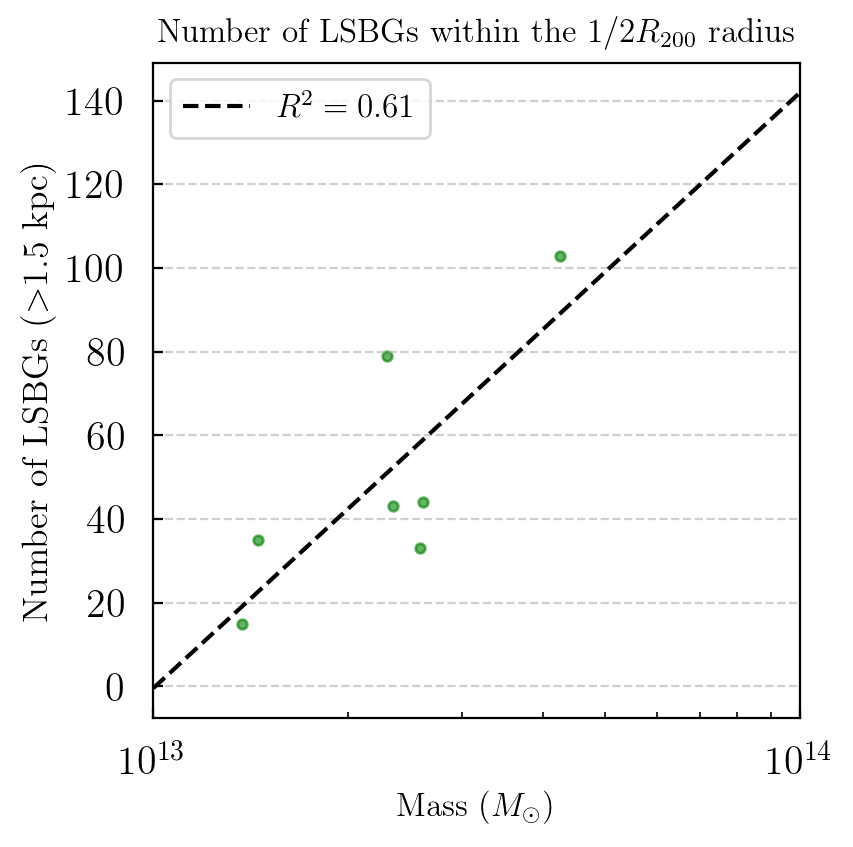

In [671]:
cut = (dist_xray>30)&(dist_xray<123)

plt.figure(figsize = (4.5,4.5))

plt.scatter(Mass_clust[cut]*(1.0e14),number_large_200[cut],c='green',alpha=0.6,s=12)
plt.plot(x,y,ls='--',c='k', label='$R^2=0.61$')
plt.xscale('log')
#plt.yscale('log')
plt.grid(ls='--', axis='both' ,alpha=0.6)

plt.title('Number of LSBGs within the $1/2 R_{200}$ radius',fontsize=12)
plt.xlabel("Mass ($M_\odot$)",fontsize=12)
plt.ylabel('Number of LSBGs ($>$1.5 kpc)',fontsize=13)

plt.xlim(1e13,1e14)

plt.legend(loc='upper left', frameon=True, fontsize=12)
plt.tight_layout()
plt.savefig('Mass_number.png', dpi=300)
plt.show()

Similar analysis for red and blue galaxies

In [672]:
## For Red Galaxies ##
# ============================================
#Calculate and print correlation coefficient between log mass an number of LSBGs
print(np.corrcoef(log_Mass,number_red[cut]))

reg_red = LinearRegression().fit(log_Mass.reshape(-1,1), number_red[cut])

print(reg_red.score(log_Mass.reshape(-1,1), number_red[cut]))

print(reg_red.coef_)
print(reg_red.intercept_)

[[1.         0.71344304]
 [0.71344304 1.        ]]
0.5090009685669589
[117.39173745]
-1530.1139754072428


In [673]:
## For Blue Galaxies ##
# ============================================
#Calculate and print correlation coefficient between log mass an number of LSBGs
print(np.corrcoef(log_Mass,number_blue[cut]))

reg_blue = LinearRegression().fit(log_Mass.reshape(-1,1), number_blue[cut])

print(reg_blue.score(log_Mass.reshape(-1,1), number_blue[cut]))

print(reg_blue.coef_)
print(reg_blue.intercept_)

[[1.         0.93452435]
 [0.93452435 1.        ]]
0.8733357648534203
[25.05423128]
-322.0409786910372


In [674]:
x = np.linspace(13,14,100)
y_red = -1530.11 + 117.4*x
x = 10**x

In [675]:
x = np.linspace(13,14,100)
y_blue = -322. + 25.05*x
x = 10**x

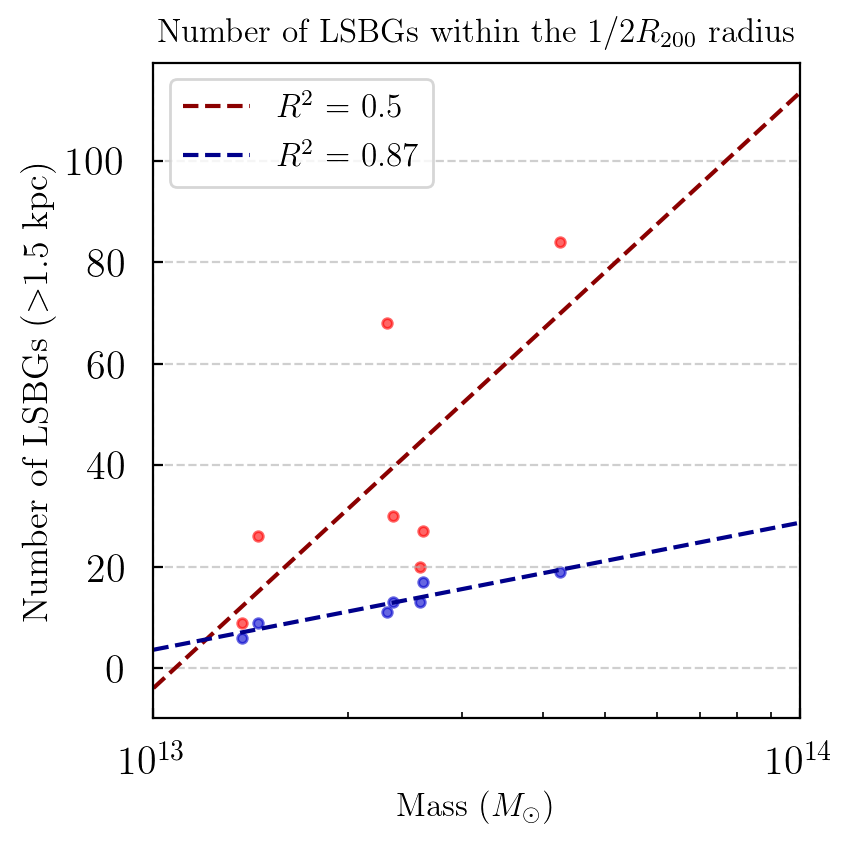

In [676]:
plt.figure(figsize = (4.5,4.5))


plt.scatter(Mass_clust[cut]*(1.0e14),number_red[cut],c='red',alpha=0.6,s=12)
plt.plot(x,y_red,ls='--',c='darkred',label='$R^2$ = 0.5')

plt.scatter(Mass_clust[cut]*(1.0e14),number_blue[cut],c='mediumblue',alpha=0.6,s=12)
plt.plot(x,y_blue,ls='--',c='darkblue',label='$R^2$ = 0.87')

plt.xscale('log')
#plt.yscale('log')
plt.grid(ls='--', axis='both' ,alpha=0.6)

plt.title('Number of LSBGs within the $1/2 R_{200}$ radius',fontsize=12)
plt.xlabel("Mass ($M_\odot$)",fontsize=12)
plt.ylabel('Number of LSBGs ($>$1.5 kpc)',fontsize=13)


plt.xlim(1e13,1e14)

plt.legend(loc='upper left', frameon=True, fontsize=12)
plt.tight_layout()
plt.tight_layout()
plt.savefig('Mass_number_blue_red.png', dpi=300)
plt.show()

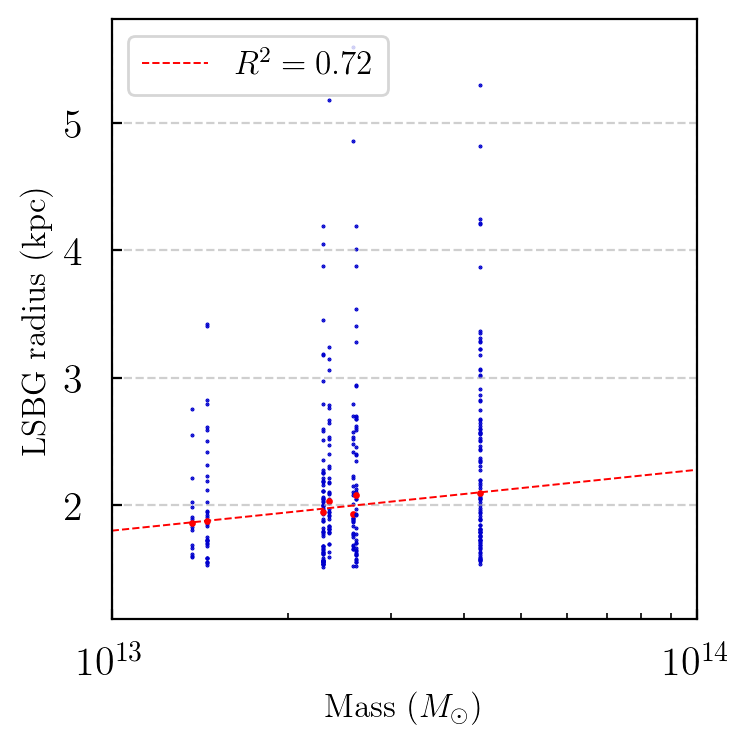

In [682]:
#print(size_large_gals)
medians = np.zeros(25)
plt.figure(figsize = (4.0,4.0))


x = np.linspace(12,14,100)
y_rad = -4.43 + 0.479*x
x = 10**x
for i in range(25):
    loc_dist = dist_xray[i]
    if ((loc_dist>30)&(loc_dist<123.)):
        size_loc = size_large_gals[i]
        median = np.median(size_loc)/1000
        n_loc = len(size_loc)
        medians[i] = median
    
    
        mass_loc = Mass_clust[i]*(1.0e14)
        mass_arr =np.zeros(n_loc)
        for j in range(n_loc):
            mass_arr[j] = mass_loc
        plt.scatter(mass_arr,size_loc/1000.,color='mediumblue',s=0.2)
        plt.scatter(mass_loc,median,color='red',s=2)
 
    plt.grid(ls='--', axis='both' ,alpha=0.6)

plt.plot(x,y_rad,c='red',ls='--',linewidth=0.7,label='$R^2=0.72$')
plt.legend(loc='upper left', frameon=True, fontsize=12)
plt.xscale('log')
plt.xlabel("Mass ($M_\odot$)",fontsize=12)
plt.ylabel('LSBG radius (kpc)',fontsize=12)
plt.xlim(1e13,1e14)
plt.tight_layout()

plt.savefig('Mass_radius.png', dpi=300)
plt.show()

Let's plot the regression line

In [681]:
log_Mass = np.log10(Mass_clust[cut]*(1.0e14))
print(len(medians))
#Calculate and print correlation coefficient between log mass an number of LSBGs
print(np.corrcoef(log_Mass,medians[cut]))

reg_medians = LinearRegression().fit(log_Mass.reshape(-1,1), medians[cut])

print(reg_medians.score(log_Mass.reshape(-1,1),medians[cut]))

print(reg_medians.coef_)
print(reg_medians.intercept_)

25
[[1.         0.85274153]
 [0.85274153 1.        ]]
0.7271681098101519
[0.47956623]
-4.434632965456118


In [618]:
x = np.linspace(12,15,100)
y_rad = 5.14 + -0.35*x
x = 10**x

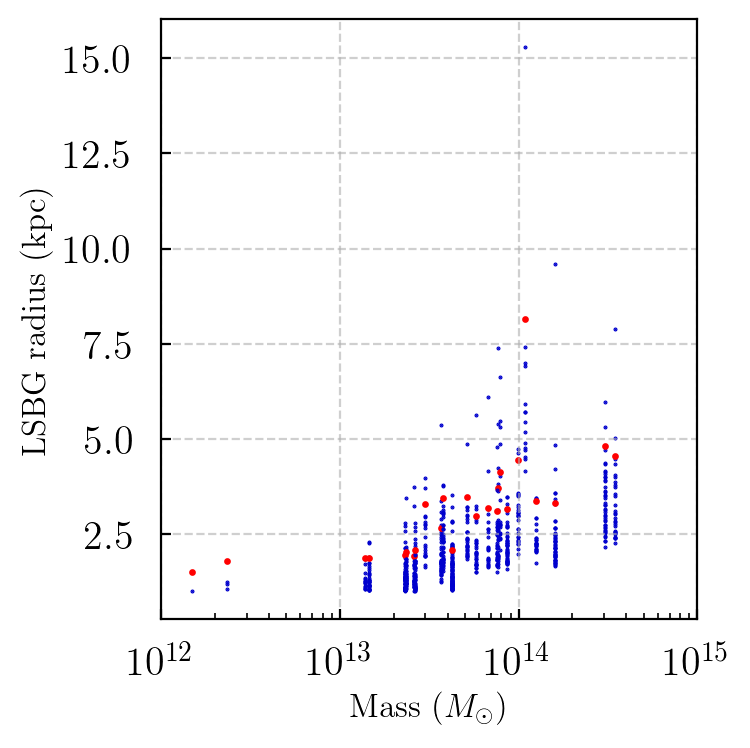

In [619]:
plt.figure(figsize = (4.0,4.0))

for i in range(25):
    size_loc = size_large_gals[i]
    median = np.median(size_loc)/1000
    n_loc = len(size_loc)
    medians[i] = median
    
    mass_loc = Mass_clust[i]*(1.0e14)
    mass_arr =np.zeros(n_loc)
    for j in range(n_loc):
        mass_arr[j] = mass_loc
    plt.scatter(mass_arr,size_loc/1000.,color='mediumblue',s=0.2)
    plt.scatter(mass_loc,median,color='red',s=2)

    
#plt.plot(x,y_rad,c='red',ls='--',linewidth=0.7,label='$R^2=0.48$')
plt.grid(ls='--', axis='both' ,alpha=0.6)
    
plt.xscale('log')
plt.xlim(1e12,1e15)
plt.xlabel("Mass ($M_\odot$)",fontsize=12)
plt.ylabel('LSBG radius (kpc)',fontsize=12)
#plt.legend(loc='upper left', frameon=True, fontsize=12)
plt.tight_layout()

plt.savefig('Mass_radius.png', dpi=300)
plt.show()

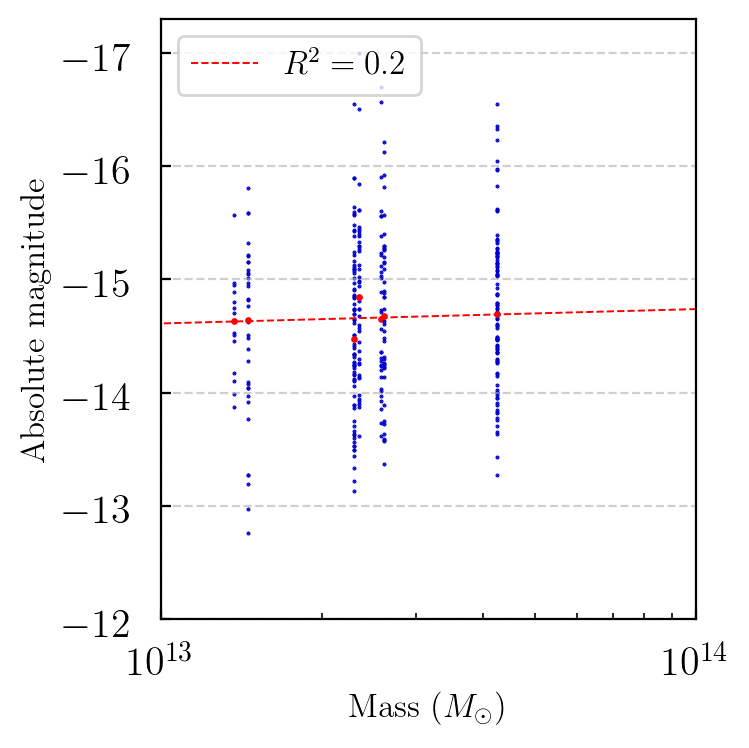

In [684]:
medians = np.zeros(25)
plt.figure(figsize = (4.0,4.0))

x = np.linspace(12,14,100)
y_rad = -12.96 -0.127*x
x = 10**x


for i in range(25):
    loc_dist = dist_xray[i]
    if ((loc_dist>30)&(loc_dist<123.)):
    
        lum_loc = abs_mags[i]
        #print(len(lum_loc))
        median = np.median(lum_loc)
        n_loc = len(lum_loc)
        medians[i] = median
    
        mass_loc = Mass_clust[i]*(1.0e14)
        mass_arr =np.zeros(n_loc)

        for j in range(n_loc):
            mass_arr[j] = mass_loc
        plt.scatter(mass_arr,lum_loc,color='mediumblue',s=0.2)
        plt.scatter(mass_loc,median,color='red',s=2)
 
plt.plot(x,y_rad,c='red',ls='--',linewidth=0.7,label='$R^2=0.2$')
plt.legend(loc='upper left', frameon=True, fontsize=12)
plt.grid(ls='--', axis='both' ,alpha=0.6)
    
plt.xscale('log')
plt.xlabel("Mass ($M_\odot$)",fontsize=12)
plt.ylabel('Absolute magnitude',fontsize=12)
plt.ylim(-12,-17.3)
plt.xlim(1e13,1e14)
plt.tight_layout()

plt.savefig('Mass_lum.png', dpi=300)
plt.show()

In [651]:
log_Mass = np.log10(Mass_clust[cut]*(1.0e14))

#Calculate and print correlation coefficient between log mass an number of LSBGs
print(np.corrcoef(log_Mass,medians[cut]))

reg_medians = LinearRegression().fit(log_Mass.reshape(-1,1), medians[cut])

print(reg_medians.score(log_Mass.reshape(-1,1),medians[cut]))

print(reg_medians.coef_)
print(reg_medians.intercept_)

[[ 1.         -0.19622934]
 [-0.19622934  1.        ]]
0.03850595270049184
[-0.12719353]
-12.962908863288407


In [114]:
x = np.linspace(12,15,100)
y_rad = 16.535 -2.3363*x
x = 10**x

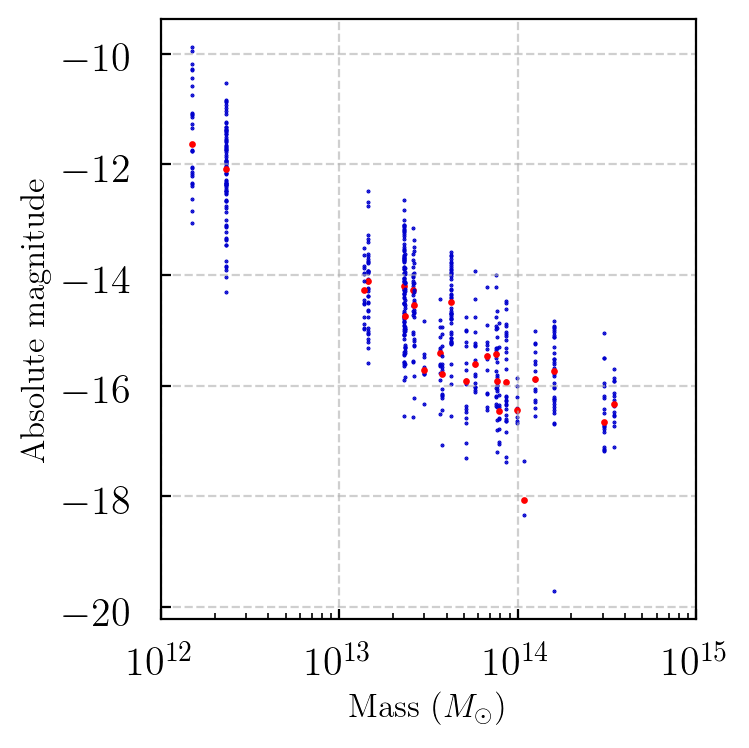

In [241]:
plt.figure(figsize = (4.0,4.0))


for i in range(25):
    lum_loc = abs_mags[i]
    median = np.median(lum_loc)
    n_loc = len(lum_loc)
    medians[i] = median
    
    mass_loc = Mass_clust[i]*(1.0e14)
    mass_arr =np.zeros(n_loc)
    for j in range(n_loc):
        mass_arr[j] = mass_loc
    plt.scatter(mass_arr,lum_loc,color='mediumblue',s=0.2)
    plt.scatter(mass_loc,median,color='red',s=2)
    
plt.grid(ls='--', axis='both' ,alpha=0.6)
#plt.plot(x,y_rad,c='red',ls='--',linewidth=0.7,label='$R^2=0.81$')
plt.grid(ls='--', axis='both' ,alpha=0.6)    
plt.xscale('log')
plt.xlabel("Mass ($M_\odot$)",fontsize=12)
plt.ylabel('Absolute magnitude',fontsize=12)
plt.xlim(1e12,1e15)
#plt.legend(loc='upper right', frameon=True, fontsize=12)
plt.tight_layout()

plt.savefig('Mass_lum.png', dpi=300)
plt.show()

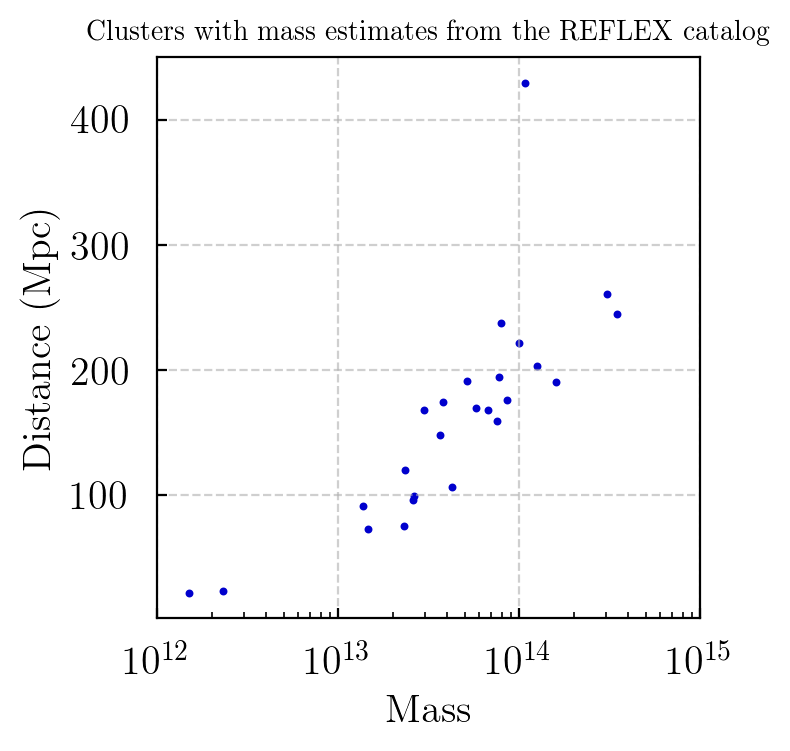

In [525]:
plt.figure(figsize = (4.0,4.0))
plt.scatter(Mass_clust*1.0e14,dist_xray,color='mediumblue',s=3.4)
plt.xscale('log')
plt.xlabel('Mass');plt.ylabel('Distance (Mpc)')
plt.grid(ls='--', axis='both' ,alpha=0.6)   
plt.title('Clusters with mass estimates from the REFLEX catalog',fontsize=10)
plt.xlim(1e12,1e15)
plt.tight_layout()
plt.savefig("mass_distance.png")
plt.show()

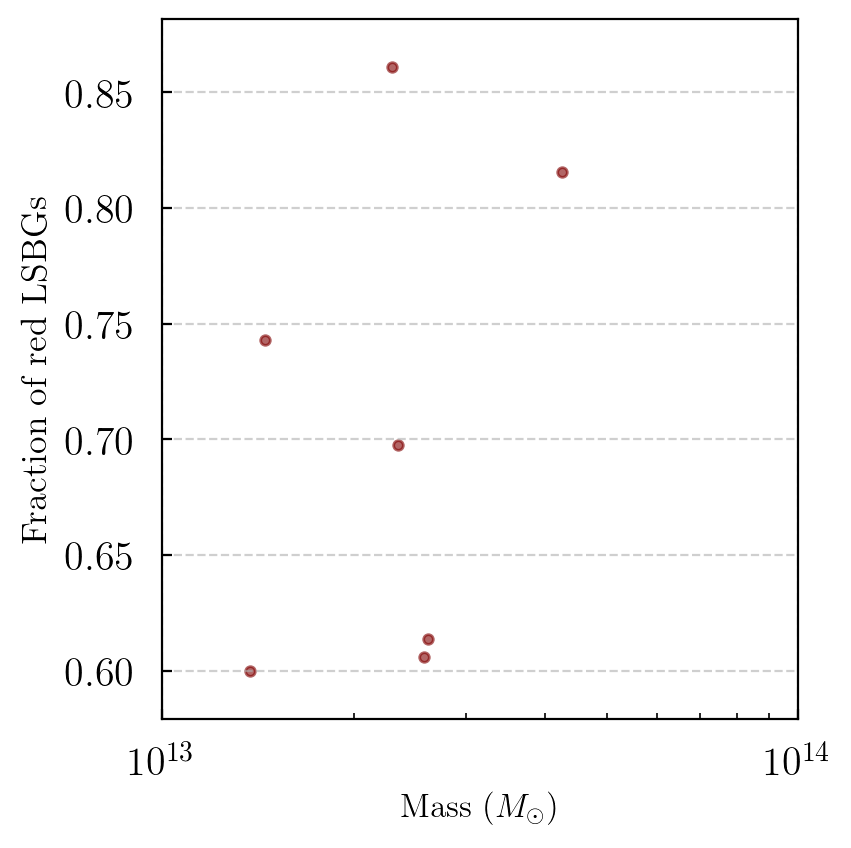

In [641]:
red_frac = number_red[cut]/(number_red[cut]+number_blue[cut])

plt.figure(figsize = (4.5,4.5))

plt.scatter(Mass_clust[cut]*(1.0e14),red_frac,c='maroon',alpha=0.6,s=12)
#plt.plot(x,y,ls='--',c='k',label='$R^2$ = 0.002')
plt.xscale('log')
#plt.yscale('log')
plt.grid(ls='--', axis='both' ,alpha=0.6)


plt.xlabel("Mass ($M_\odot$)",fontsize=12)
plt.ylabel('Fraction of red LSBGs',fontsize=13)

plt.xlim(1e13,1e14)
#plt.ylim(0.6,)

plt.tight_layout()
plt.savefig('fraction_red.png', dpi=300)
plt.show()

In [118]:
Mass_clust

array([0.2298341 , 0.02317366, 0.42471948, 0.14528407, 0.23467403,
       1.58775151, 0.86026499, 0.36695315, 0.25799544, 0.37777964,
       0.51567815, 0.99306716, 3.04913102, 0.26157318, 1.07771751,
       0.76932611, 0.57373069, 1.25055974, 0.13717302, 0.75095584,
       0.78928843, 0.67026288, 3.47345764, 0.01490158, 0.2981168 ])

In [119]:
print(names)

['Abell 194' 'RXC J0340.1-1835' 'Abell 2877' 'RXC J0125.5+0145'
 'Abell 2806' 'Abell 119' 'RXC J0548.6-2527' 'RXC J0454.8-1806'
 'Abell S301' 'Abell S463' 'RXC J0542.1-2607' 'Abell S861' 'Abell 3266'
 'RXC J0252.8-0116' 'RXC J0108.9-1537' 'Abell 168' 'RXC J0137.2-0912'
 'Abell 3376' 'RXC J2347.4-0218' 'Abell S540' 'Abell 3301' 'Abell 3341'
 'Abell 3667' 'RXC J0152.9-1345' 'RXC J2151.3-5521']


In [416]:
ra_loc = ra_xray[0:25]
dec_loc = dec_xray[0:25]
dist_loc = dist_xray[0:25]
mass_loc = Mass_clust[0:25]
names_loc = names[0:25]
R_200_loc = R_200_s[0:25]
print(dist_loc)
print(ra_loc[9])
print(dec_loc[9])
print(dist_loc[9])
print(names_loc[9])
print(mass_loc[9])
print(R_200_loc[9])

[ 75.07  23.41 106.41  72.32 120.23 190.58 175.61 147.75  96.24 174.16
 190.62 220.99 260.57  99.2  429.38 194.31 169.12 202.95  91.06 159.23
 237.21 168.2  244.3   21.87 167.88]
67.2825
-53.8475
174.16
Abell S463
0.37777964220108173
2.130127514514279


In [121]:
xray_df = pd.DataFrame( OrderedDict((
    ('name_xray',pd.Series(names)), 
    ('ra_xray', pd.Series(ra_xray)),
    ('dec_xray', pd.Series(dec_xray)),
    ('z_xray', pd.Series(z_xray)),
    ('dist_xray', pd.Series(dist_xray)),
    ('mass_xray', pd.Series(Mass_clust)),
    ('lum_xray', pd.Series(Lum))
 
)))

In [122]:
xray_df.to_csv('xray_info.csv')

##### Case studies

Let's explore what's going on with two peaks.

For example around RXC J0548.6-2527


It has coordinates (87.165,-25.4584) and is associated with the peak at (87.174635,-25.488722)

In [425]:
ra_peak_loc =67.2825
dec_peak_loc = -53.8475

angle = 10.0

ra_min = ra_peak_loc - angle
ra_max = ra_peak_loc + angle

dec_min = dec_peak_loc - angle
dec_max = dec_peak_loc + angle

In [426]:
# Box for Abell
box_Abell = (ra_Abell>ra_min)&(ra_Abell<ra_max)&(dec_Abell>dec_min)&(dec_Abell<dec_max)
# Box for Reflex 
box_Reflex = (ra_Reflex>ra_min)&(ra_Reflex<ra_max)&(dec_Reflex>dec_min)&(dec_Reflex<dec_max)
# Box NGC 
box_NGC = (ra_NGC>ra_min)&(ra_NGC<ra_max)&(dec_NGC>dec_min)&(dec_NGC<dec_max)
# Box 2Mass
box_2Mass = (ra_2Mass>ra_min)&(ra_2Mass<ra_max)&(dec_2Mass>dec_min)&(dec_2Mass<dec_max)
# Box LSBGs
box_LSBGs = (ra>ra_min)&(ra<ra_max)&(dec>dec_min)&(dec<dec_max)
# ===========================================================================
# ===========================================================================
# Abell
ra_Abell_box = ra_Abell[box_Abell];dec_Abell_box=dec_Abell[box_Abell]
name_Abell_box = name_Abell[box_Abell]
z_Abell_box = z_Abell[box_Abell];rich_Abell_box = rich_Abell[box_Abell];dist_Abell_box = dist_Abell[box_Abell]
# Reflex
ra_Reflex_box = ra_Reflex[box_Reflex];dec_Reflex_box=dec_Reflex[box_Reflex]
name_Reflex_box = name_Reflex[box_Reflex];z_Reflex_box = z_Reflex[box_Reflex]
# NGC 
ra_NGC_box = ra_NGC[box_NGC];dec_NGC_box=dec_NGC[box_NGC]
name_NGC_box = name_NGC[box_NGC]
# 2Mass 
ra_2Mass_box = ra_2Mass[box_2Mass];dec_2Mass_box=dec_2Mass[box_2Mass]
name_2Mass_box = name_2Mass[box_2Mass];Nmb_2Mass_box = Nmb_2Mass[box_2Mass]
# LSBGs
ra_LSBG = ra[box_LSBGs];dec_LSBG = dec[box_LSBGs]                                                                         

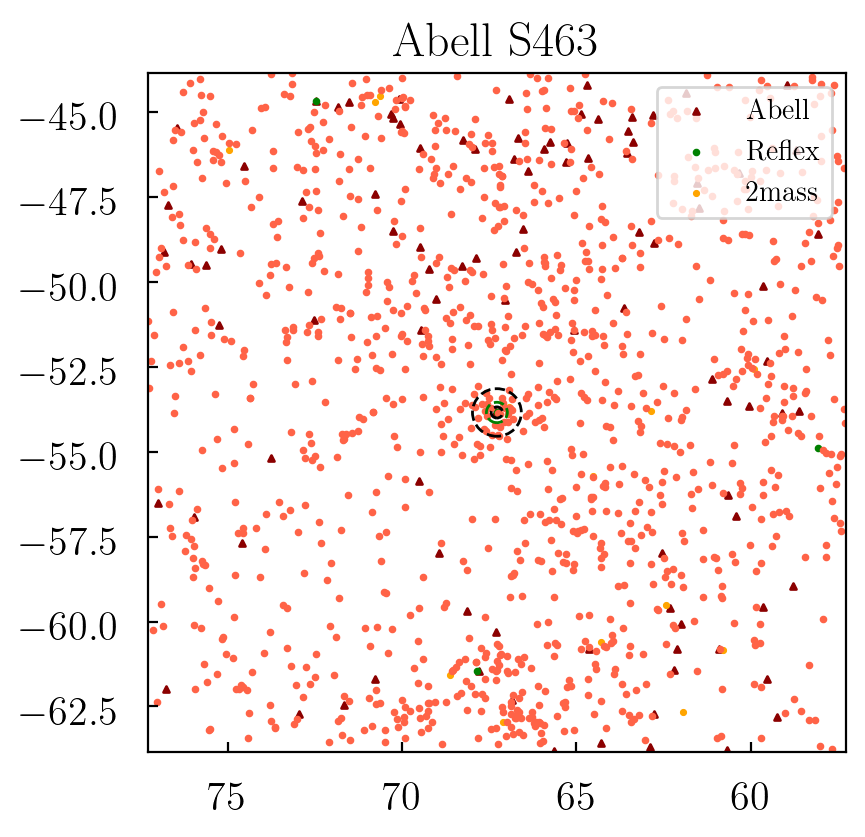

In [427]:

from matplotlib import patches

fig, ax = plt.subplots(figsize=(4.5,4.5))

ax.scatter(ra_peak_loc, dec_peak_loc, c='k', s=10.5, marker='x')
ax.scatter(ra_Abell_box, dec_Abell_box, c='darkred', marker='^', s=4.5, label='Abell')
ax.scatter(ra_Reflex_box, dec_Reflex_box, c='g', s=3.0, label='Reflex')
#ax.scatter(ra_NGC_box, dec_NGC_box, c='mediumblue', s=5.5, label='NGC')
ax.scatter(ra_2Mass_box, dec_2Mass_box, c='orange', s=2.5, label='2mass ')
ax.scatter(ra_LSBG, dec_LSBG, c='tomato', s=3)

ax.add_patch(patches.Circle((ra_peak_loc,dec_peak_loc),
                             radius=0.164,
                             color='k', linewidth=1,ls='--', fill=False))

ax.add_patch(patches.Circle((ra_peak_loc,dec_peak_loc),
                             radius=0.30,
                             color='green', linewidth=1,ls='--', fill=False))

ax.add_patch(patches.Circle((ra_peak_loc,dec_peak_loc),
                             radius=0.70,
                             color='k', linewidth=1,ls='--', fill=False))
plt.title('Abell S463')

plt.legend(frameon=True, loc='upper right', fontsize=10)
#plt.legend(loc='upper right', frameon=True, fontsize=8)
plt.xlim(ra_max,ra_min);plt.ylim(dec_min,dec_max)
#plt.xlim(0,100);plt.ylim(-80,10)
plt.savefig('Cluster5_zoom5deg.png')
plt.show()

In [401]:
name_Reflex_box

chararray(['RXC J2011.3-5725', 'RXC J2012.5-5649', 'RXC J2032.1-5627',
           'RXC J2023.4-5535', 'RXC J2009.0-5421', 'RXC J2021.9-5256',
           'RXC J2018.7-5242', 'RXC J1953.0-5201'], dtype='|S16')

In [332]:
import skymap as smap
from skymap import DESSkymap

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


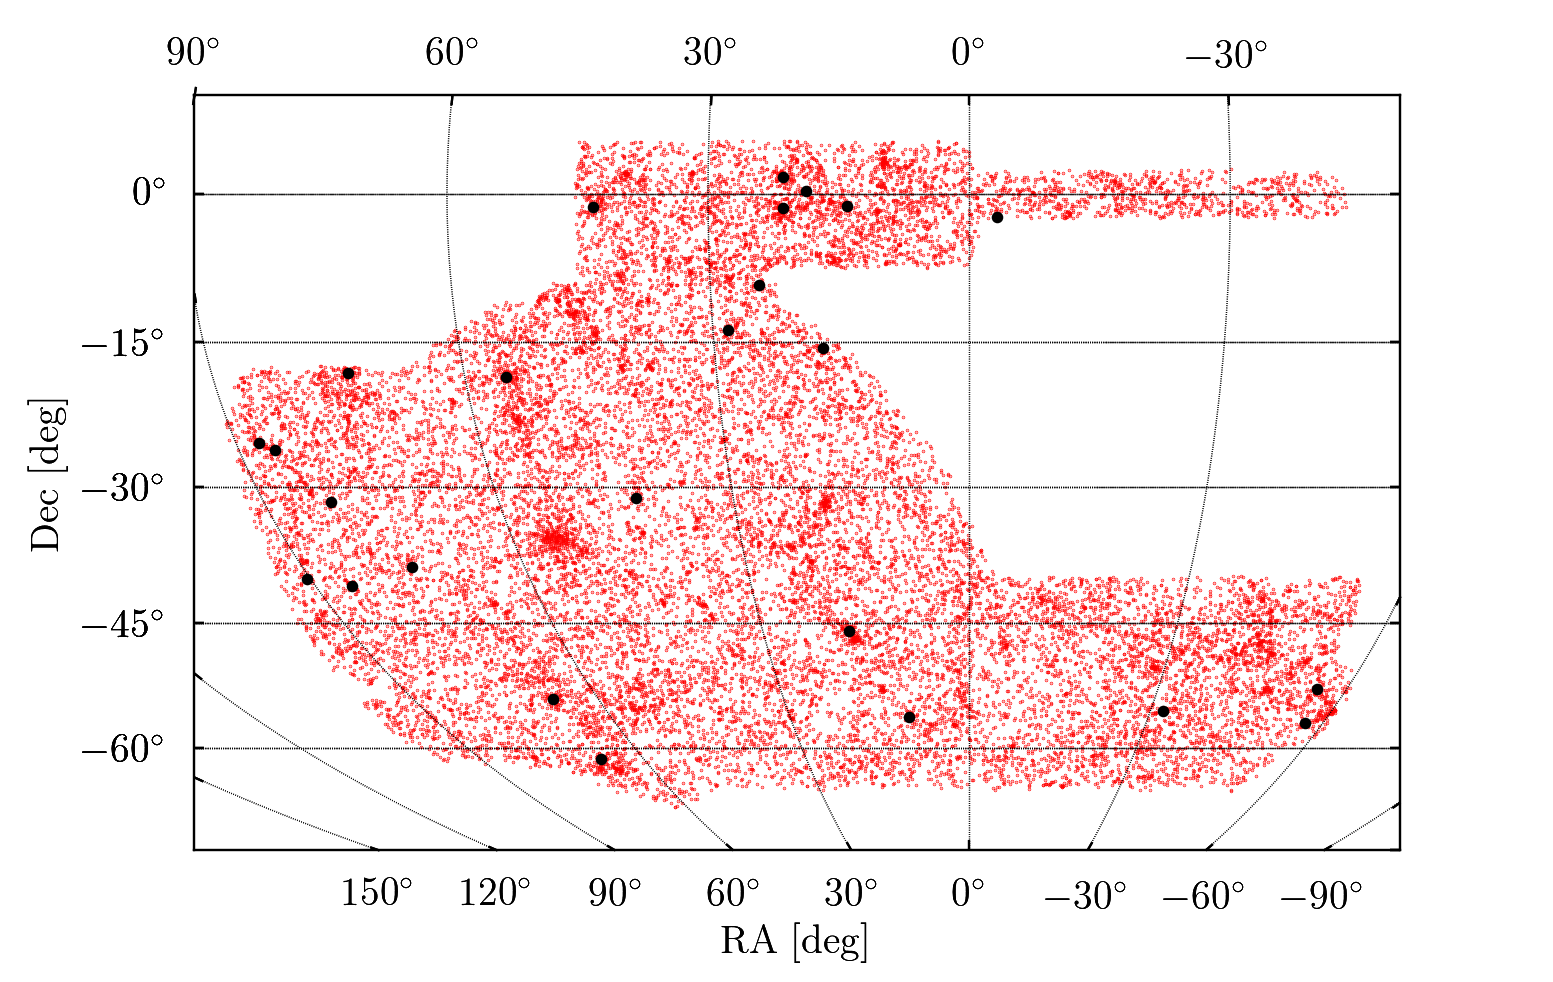

In [322]:
plt.figure(figsize = (8.0,5.0))

smap = DESSkymap()

smap.scatter(ra, dec, c='red',rasterized=True, s=0.05,latlon=True)
#smap.draw_des(color='k',linewidth=0.7,label='DES footprint')

smap.scatter(ra_loc,dec_loc,c='k',s=10,latlon=True)

plt.xlabel("RA [deg]", fontsize=20)
plt.ylabel("Dec [deg]", fontsize=20)

#plt.legend(frameon=True, loc='upper left', fontsize=12)
plt.tight_layout()
#plt.savefig('Footprint.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
#plt.savefig('Reds.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()